In [1]:
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pylab import rcParams
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import plotly.io as pio
import plotly.graph_objs as go

In [61]:
df_apple = pd.read_csv("AAPL_new.csv")
df_apple

,Date,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,1999-11-01,80.00,80.6900,77.37,77.62,0.589041,2487300,0.0,1.0
1,1999-11-02,78.00,81.6900,77.31,80.25,0.608999,3564600,0.0,1.0
2,1999-11-03,81.62,83.2500,81.00,81.50,0.618485,2932700,0.0,1.0
3,1999-11-04,82.06,85.3700,80.62,83.62,0.634574,3384700,0.0,1.0
4,1999-11-05,84.62,88.3700,84.00,88.31,0.670165,3721500,0.0,1.0
...,...,...,...,...,...,...,...,...,...
5882,2023-03-20,155.07,157.8200,154.15,157.40,157.400000,73641415,0.0,1.0
5883,2023-03-21,157.32,159.4000,156.54,159.28,159.280000,73938285,0.0,1.0
5884,2023-03-22,159.30,162.1400,157.81,157.83,157.830000,75701811,0.0,1.0
5885,2023-03-23,158.83,161.5501,157.68,158.93,158.930000,67622060,0.0,1.0


In [62]:
df_apple['Date'] = pd.to_datetime(df_apple['Date'])
df_apple.set_index('Date', inplace=True)

In [63]:
df_apple = df_apple[['close']]
df_apple

,close
Date,
1999-11-01,77.62
1999-11-02,80.25
1999-11-03,81.50
1999-11-04,83.62
1999-11-05,88.31
...,...
2023-03-20,157.40
2023-03-21,159.28
2023-03-22,157.83


In [64]:
df_obt = df_apple.copy()

In [65]:
df_obt = df_obt.drop(df_obt.index[:1000])
df_obt

,close
Date,
2003-10-24,22.60
2003-10-27,22.60
2003-10-28,23.72
2003-10-29,23.69
2003-10-30,23.09
...,...
2023-03-20,157.40
2023-03-21,159.28
2023-03-22,157.83


### EDA

(array([10957., 12418., 13879., 15340., 16801., 18262., 19723.]),
 [Text(10957.0, 0, '2000'),
  Text(12418.0, 0, '2004'),
  Text(13879.0, 0, '2008'),
  Text(15340.0, 0, '2012'),
  Text(16801.0, 0, '2016'),
  Text(18262.0, 0, '2020'),
  Text(19723.0, 0, '2024')])

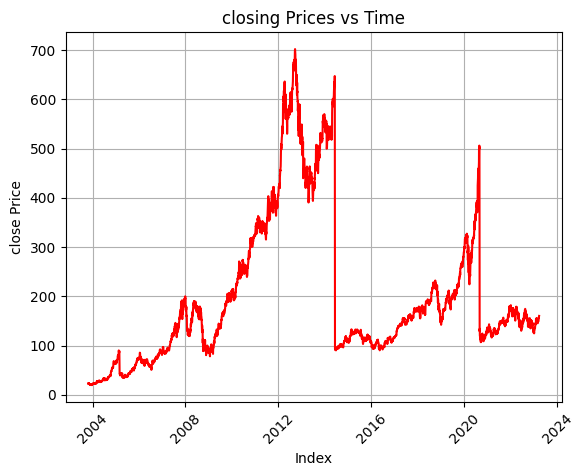

In [7]:
plt.plot(df_obt, color = 'red', linestyle = '-')
plt.xlabel('Index')
plt.ylabel('close Price')
plt.grid(True)
plt.title("closing Prices vs Time")
plt.xticks(rotation = 45)


### Let's capture Trends, seasonality and Noise in the Dataset.

In [8]:

stl = STL(df_obt["close"], period=12) 
res = stl.fit()
seasonal, trend, residual = res.seasonal, res.trend, res.resid

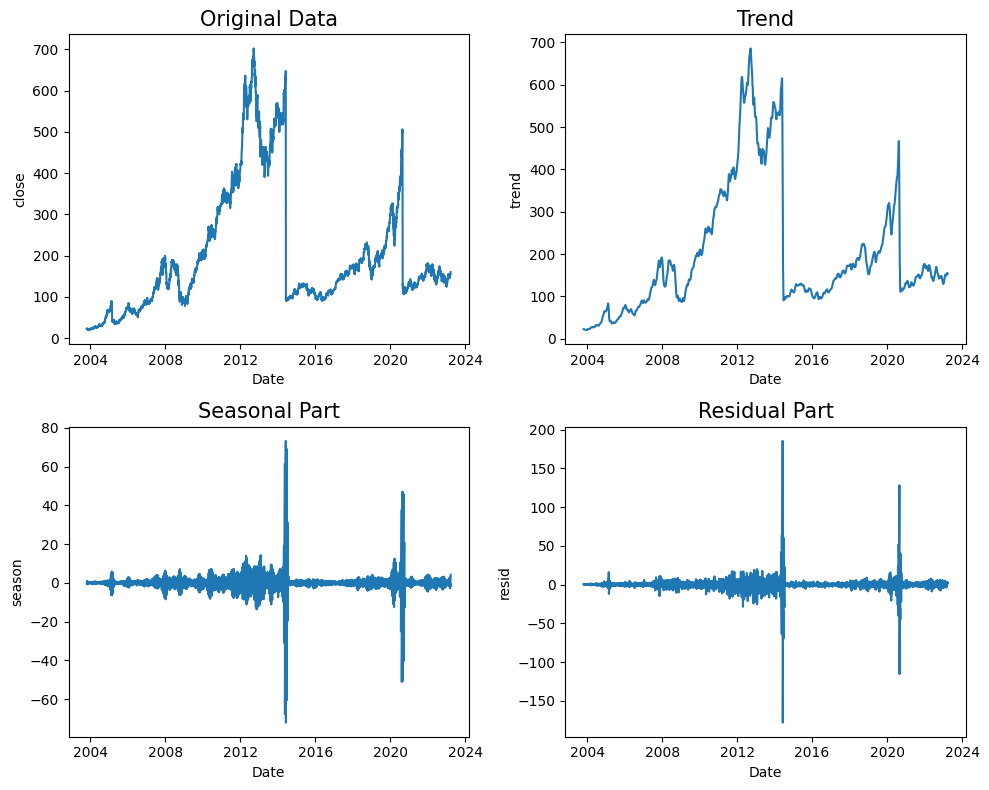

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot 1 - Original Data
sns.lineplot(x=df_obt.index, y=df_obt['close'], ax=axs[0, 0])
axs[0, 0].set_title('Original Data', fontsize=15)

# Plot 2 - Trend
sns.lineplot(x=trend.index, y=trend, ax=axs[0, 1])
axs[0, 1].set_title('Trend', fontsize=15)

# Plot 3 - Seasonal
sns.lineplot(x=seasonal.index, y=seasonal, ax=axs[1, 0])
axs[1, 0].set_title('Seasonal Part', fontsize=15)

# Plot 4 - Residual
sns.lineplot(x=residual.index, y=residual, ax=axs[1, 1])
axs[1, 1].set_title('Residual Part', fontsize=15)

plt.tight_layout()
plt.show()


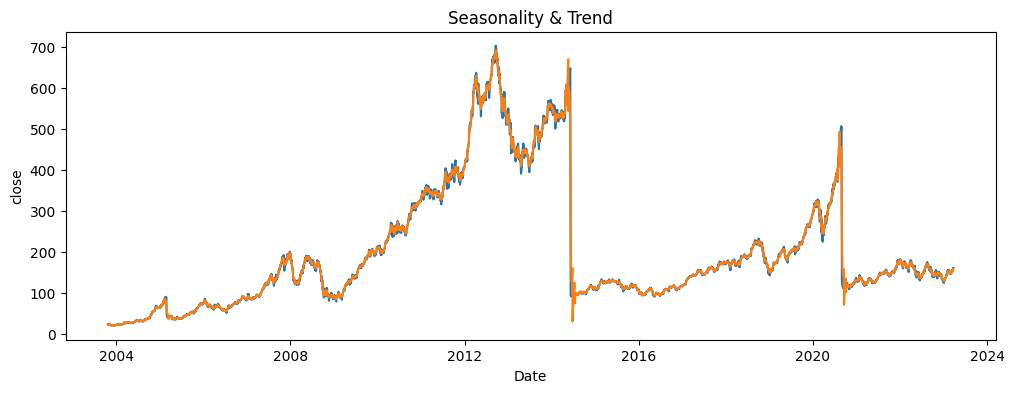

In [10]:
estimated_data = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(df_obt)
plt.title('Seasonality & Trend')
plt.xlabel('Date')
plt.ylabel("close")
plt.plot(estimated_data)

### Anomaly detection Using STL techniques

In [11]:
mu_residual = residual.mean()
resid_dev = residual.std()

lower = mu_residual - 3*resid_dev
upper = mu_residual + 3*resid_dev

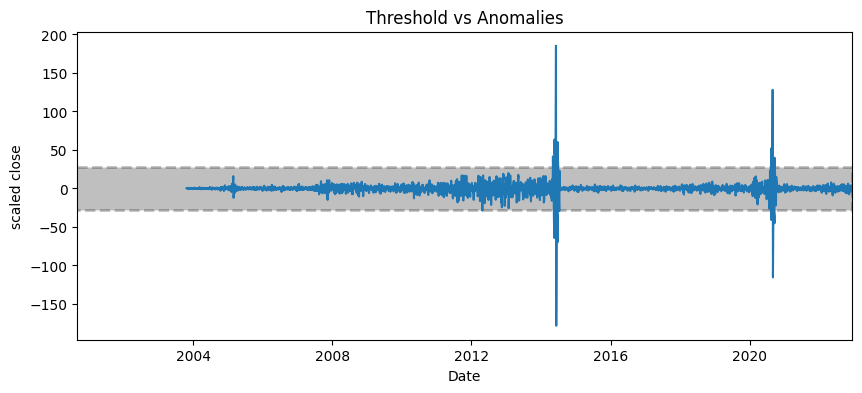

In [12]:
import datetime
plt.figure(figsize=(10,4))
plt.plot(residual)

plt.fill_between([datetime.datetime(2000,1,1), datetime.datetime(2022,12,12)], lower, upper, color='black', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime.datetime(2000,9,1), datetime.datetime(2022,12,12))
plt.title('Threshold vs Anomalies')
plt.xlabel('Date')
plt.ylabel('scaled close')

plt.show()

In [13]:
anomalies = df_obt[(residual < lower) | (residual > upper)]
anomalies.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2012-04-24 to 2020-09-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes


In [14]:
anomalies.head()

,close
Date,
2012-04-24,560.28
2014-05-05,600.96
2014-05-06,594.41
2014-05-15,588.82
2014-05-16,597.51


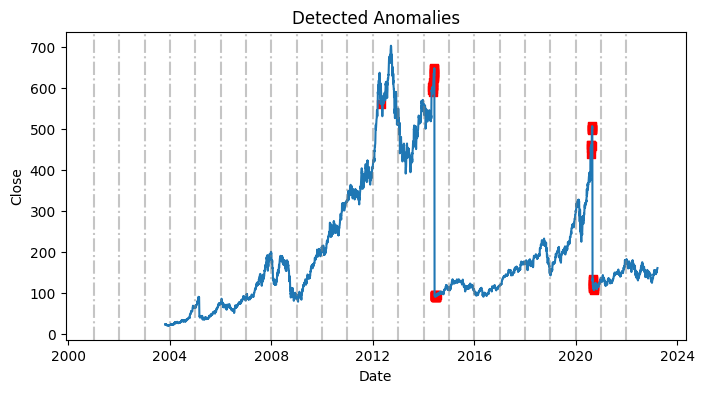

In [15]:
plt.figure(figsize=(8,4))
plt.plot(df_obt)
for years in range(2001,2023):
    plt.axvline(datetime.datetime(years,1,1), color='gray', linestyle='-.', alpha=0.45)
    
plt.scatter(anomalies.index, anomalies.close, color='red', marker='s')
plt.title('Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

### Now let's use LSTM to find anomlaies

In [66]:
size_train = int(len(df_obt)*0.80) 
size_test = len(df_obt) - size_train 
train_data, test_data = df_obt.iloc[0:size_train], df_obt.iloc[size_train:len(df_obt)]
train_data

,close
Date,
2003-10-24,22.60
2003-10-27,22.60
2003-10-28,23.72
2003-10-29,23.69
2003-10-30,23.09
...,...
2019-05-01,210.52
2019-05-02,209.15
2019-05-03,211.75


In [67]:
test_data

,close
Date,
2019-05-08,202.90
2019-05-09,200.72
2019-05-10,197.18
2019-05-13,185.72
2019-05-14,188.66
...,...
2023-03-20,157.40
2023-03-21,159.28
2023-03-22,157.83


In [68]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
train_close = scaler.fit_transform(train_data[['close']])
test_close = scaler.transform(test_data[['close']])

train_data['close'] = train_close
test_data['close'] = test_close

<ipython-input-68-36d051607ae4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['close'] = train_close
<ipython-input-68-36d051607ae4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['close'] = test_close


In [69]:
size_window = 30

def create_seq(X, y, steps_time=size_window):
    """
    Creates sequential data for LSTM model training.
    time_steps (int): The number of time steps for each sequence.

    Returns:
    tuple: A tuple containing the sequential input data and target variable.
    """
    Xs = []
    ys=[]
    for i in range(len(X)-steps_time):
        Xs.append(X[i : i + steps_time])
        ys.append(y[i + steps_time])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_seq(train_data[['close']], train_data['close'])
X_test, y_test = create_seq(test_data[['close']], test_data['close'])

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')



Train shape: (3879, 30, 1)
Test shape: (948, 30, 1)


### Hyper-Parameter Tuning

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

def create_model(units=128, dropout_rate=0.2, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=dropout_rate))
    model.add(RepeatVector(X_train.shape[1]))
    model.add(LSTM(units=64, activation=activation, return_sequences=True))
    model.add(Dropout(rate=dropout_rate))
    model.add(TimeDistributed(Dense(X_train.shape[2])))
    model.compile(optimizer=optimizer, loss='mae')
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)
param_grid = {'units': [64,128],
              'dropout_rate': [0.1,0.2],
              'activation': ['relu','tanh'],
              'optimizer': ['adam']}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-119-3191e2bb7acd>:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best: -0.726272 using {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'adam', 'units': 64}


### Final Model using Best parameters

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential()

# Add LSTM layer with adjusted hyperparameters
model.add(LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mae')


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 30, 64)            49408     
                                                                 
 dropout_5 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1)            65        
 tributed)                                            

In [71]:
from tensorflow import keras
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


Epoch 1/10
110/110 [==============================] - 10s 67ms/step - loss: 0.4745 - val_loss: 0.0729
Epoch 2/10
110/110 [==============================] - 8s 71ms/step - loss: 0.1977 - val_loss: 0.0720
Epoch 3/10
110/110 [==============================] - 8s 69ms/step - loss: 0.1680 - val_loss: 0.1050
Epoch 4/10
110/110 [==============================] - 7s 64ms/step - loss: 0.1646 - val_loss: 0.0847
Epoch 5/10
110/110 [==============================] - 8s 72ms/step - loss: 0.1631 - val_loss: 0.0488
Epoch 6/10
110/110 [==============================] - 7s 61ms/step - loss: 0.1471 - val_loss: 0.0713
Epoch 7/10
110/110 [==============================] - 8s 72ms/step - loss: 0.1475 - val_loss: 0.0515
Epoch 8/10
110/110 [==============================] - 7s 62ms/step - loss: 0.1524 - val_loss: 0.0589


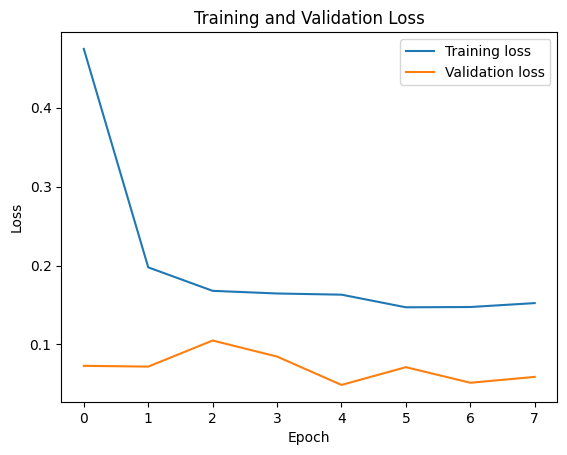

In [72]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [73]:
model.evaluate(X_test, y_test)

30/30 [==============================] - 1s 20ms/step - loss: 0.1131


0.11310555040836334

Reconstruction error threshold: 0.4147007588482526


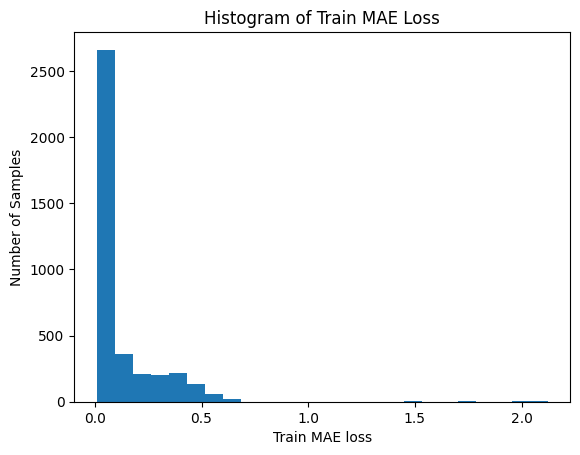

In [75]:
Xtrain_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(Xtrain_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=25)
plt.xlabel('Train MAE loss')
plt.title('Histogram of Train MAE Loss');
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
threshold = np.percentile(train_mae_loss,93)
print(f'Reconstruction error threshold: {threshold}')

Reconstruction error threshold: 0.5647178546241095


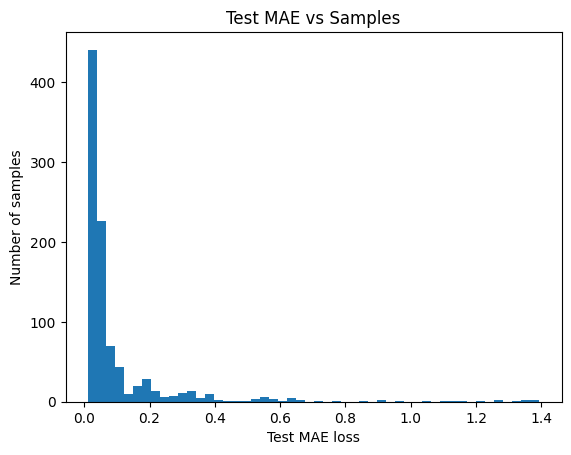

In [76]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')
plt.title("Test MAE vs Samples");
threshold_test = np.percentile(test_mae_loss,97)
print(f'Reconstruction error threshold: {threshold_test }')

In [77]:
test_score_df = pd.DataFrame(test_data[size_window:])
test_score_df

,close
Date,
2019-06-20,-0.028922
2019-06-21,-0.033059
2019-06-24,-0.034276
2019-06-25,-0.052588
2019-06-26,-0.026853
...,...
2023-03-20,-0.284813
2023-03-21,-0.273376
2023-03-22,-0.282197


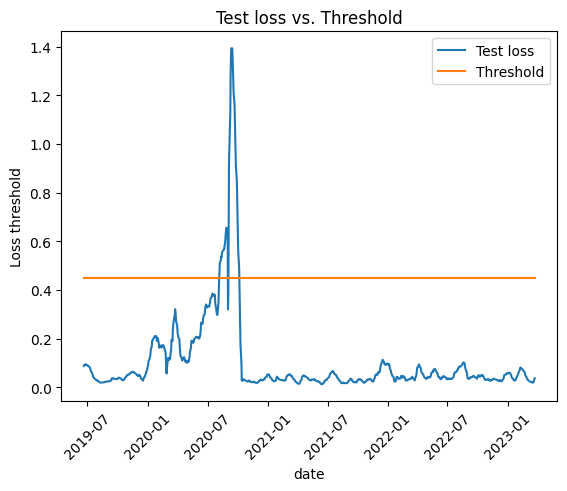

In [80]:
import matplotlib.pyplot as plt

test_score_df['Date'] = test_data[size_window:].index
test_score_df['loss'] = test_mae_loss
threshold = 0.45
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['close'] = test_data[size_window:]['close']

plt.plot(test_score_df['Date'], test_score_df['loss'], label='Test loss')
plt.plot(test_score_df['Date'], test_score_df['threshold'], label='Threshold')
plt.xlabel("date")
plt.ylabel("Loss threshold")
plt.legend()
plt.xticks(rotation=45)
plt.title('Test loss vs. Threshold')
plt.show()



In [81]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(40, 5)

In [82]:
anomalies

,close,Date,loss,threshold,anomaly
Date,,,,,
2020-08-06,1.529487,2020-08-06,0.470521,0.45,True
2020-08-07,1.461590,2020-08-07,0.510370,0.45,True
2020-08-10,1.500893,2020-08-10,0.521804,0.45,True
2020-08-11,1.419307,2020-08-11,0.537314,0.45,True
2020-08-12,1.507768,2020-08-12,0.532324,0.45,True
2020-08-13,1.556439,2020-08-13,0.541583,0.45,True
2020-08-14,1.553945,2020-08-14,0.555137,0.45,True
2020-08-17,1.546644,2020-08-17,0.561612,0.45,True
2020-08-18,1.569885,2020-08-18,0.563471,0.45,True


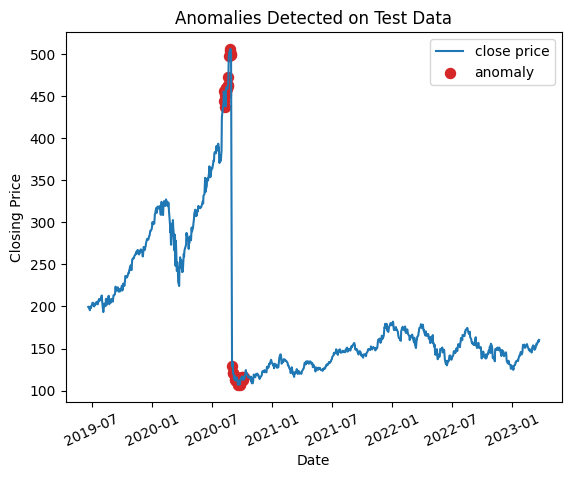

In [83]:
plt.plot(
  test_data[size_window:].index, 
  scaler.inverse_transform(test_data[size_window:].close.values.reshape(-1, 1)), 
  label='close price'
)

plt.scatter(
  anomalies.index,
  scaler.inverse_transform(anomalies.close.values.reshape(-1, 1)),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title('Anomalies Detected on Test Data')
plt.legend()

In [84]:
df_obt

,close
Date,
2003-10-24,22.60
2003-10-27,22.60
2003-10-28,23.72
2003-10-29,23.69
2003-10-30,23.09
...,...
2023-03-20,157.40
2023-03-21,159.28
2023-03-22,157.83


### Removing anomalies from Dataframe.

In [85]:
anomaly_dates = anomalies[anomalies['anomaly']]['Date']
df_new = df_obt[~df_obt.index.isin(anomaly_dates)]

In [86]:
df_obt

,close
Date,
2003-10-24,22.60
2003-10-27,22.60
2003-10-28,23.72
2003-10-29,23.69
2003-10-30,23.09
...,...
2023-03-20,157.40
2023-03-21,159.28
2023-03-22,157.83


In [87]:
df_anom_removed = df_new.copy()

In [88]:
df_anom_removed

,close
Date,
2003-10-24,22.60
2003-10-27,22.60
2003-10-28,23.72
2003-10-29,23.69
2003-10-30,23.09
...,...
2023-03-20,157.40
2023-03-21,159.28
2023-03-22,157.83


### Forecasting Using LSTM

In [89]:
forecast_df = df_anom_removed['close'].iloc[:-4]

In [90]:
import math
train_len = math.ceil(len(forecast_df)*0.8)
train_len

3875

In [91]:
window=10

train_data = forecast_df[0:train_len]

X_train=[]
Y_train=[]

for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])

In [92]:
X_train, Y_train= np.array(X_train), np.array(Y_train)

In [93]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3865, 10, 1)

In [94]:
from keras.layers import Dense, LSTM, Dropout

In [95]:
model=Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                10400     
                                                                 
 dense_5 (Dense)             (None, 25)                1275      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


In [96]:
test_data = forecast_df[train_len-window:]

X_val=[]
Y_val=[] 

for i in range(window, len(test_data)):
    X_val.append(test_data[i-window:i])
    Y_val.append(test_data[i])

In [97]:
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

In [98]:
prediction = model.predict(X_val)

31/31 [==============================] - 0s 3ms/step


In [99]:
len(prediction), len(Y_val)

(968, 968)

In [100]:
from sklearn.metrics import mean_squared_error

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))

31/31 [==============================] - 0s 2ms/step
Train rmse: 13.095872034422117
Validation rmse: 12.53869478583823


### I have ran the model without removing anomalies, I got a rmse of 13.81, now after anomlaies removed, I got 11.75(keeps changing everytime I run) . Lot of improvement and yes feature engineering techniques worked pretty well !!

In [101]:
valid = pd.DataFrame(forecast_df[train_len:])
valid['Predictions']=lstm_valid_pred
valid

,close,Predictions
Date,,
2019-03-20,188.16,190.119675
2019-03-21,195.09,191.096771
2019-03-22,191.05,195.283875
2019-03-25,188.74,195.097504
2019-03-26,186.79,194.460190
...,...,...
2023-03-14,152.59,155.015732
2023-03-15,152.99,155.939072
2023-03-16,155.85,157.018723


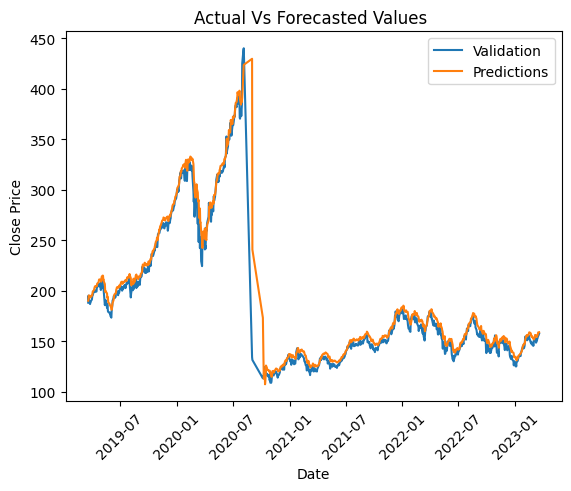

In [104]:
plt.plot(valid[['close','Predictions']])
plt.legend(['Validation','Predictions'])
plt.xticks(rotation = 45)
plt.title('Actual Vs Forecasted Values ')
plt.ylabel("Close Price")
plt.xlabel("Date")
plt.show()